# jaxeffort introduction

In this notebook we will show how to use some capabilities from `jaxeffort`.In this tutorial you will learn how to instantiate some trained emulators, run them and get jacobians as evaluated from AD systems.

We start by loading the required packages.

In [1]:
import numpy as np
import jaxeffort
import jax
import matplotlib.pyplot as plt
import json
plt.rcParams['text.usetex'] = True

Initializing neutrino interpolants with dual-grid strategy...
Creating F_interpolant grid...
Creating dFdy_interpolant grid...
F grid: 1100 points from 0.001000 to 1000.0
dFdy grid: 20000 points from 0.001000 to 1000.0
Computing F values...
Computing dFdy values...
Creating Akima interpolators...
Dual-grid interpolants initialized successfully!
jaxeffort: Initializing multipole emulators...
  Loading pybird_mnuw0wacdm...
  pybird_mnuw0wacdm: Loaded 3/3 multipoles (l=['0', '2', '4'])
  Loading velocileptors_lpt_mnuw0wacdm...
  velocileptors_lpt_mnuw0wacdm: Loaded 3/3 multipoles (l=['0', '2', '4'])
  Loading velocileptors_rept_mnuw0wacdm...
  velocileptors_rept_mnuw0wacdm: Loaded 3/3 multipoles (l=['0', '2', '4'])


`jaxeffort` comes batteries included with some trained emulators. They can be accessed by

In [2]:
P0 = jaxeffort.trained_emulators["velocileptors_rept_mnuw0wacdm"]["0"]
P2 = jaxeffort.trained_emulators["velocileptors_rept_mnuw0wacdm"]["2"]
P4 = jaxeffort.trained_emulators["velocileptors_rept_mnuw0wacdm"]["4"]

You can get a description of the emulator, together with the parameters the emulator handles, by

In [3]:
P0.P11.emulator_description

{'author': 'Marco Bonici',
 'author_email': 'bonici.marco@gmail.com',
 'miscellanea': 'The emulator has been trained using CLASS and velocileptors. The training dataset has been created by passing P_cb to velocileptors, assuming there is only one massive neutrino.',
 'parameters': 'z, ln10^10 As, ns, H0, omega_b, omega_c, Mnu, w0, wa.'}

You can see their input parameter ranges by (they are in the same order as in the above description)

In [4]:
P0.P11.in_MinMax

Array([[ 2.85004037e-01,  1.89999596e+00],
       [ 2.00000375e+00,  3.49999625e+00],
       [ 8.00000750e-01,  1.09999775e+00],
       [ 5.00001000e+01,  8.99999000e+01],
       [ 2.00000125e-02,  2.49999875e-02],
       [ 8.00002500e-02,  1.79999750e-01],
       [ 3.75000000e-06,  4.99996250e-01],
       [-2.99999125e+00,  4.99991250e-01],
       [-2.99998750e+00,  1.99998750e+00]], dtype=float64)

Now, let us come to the usage of `jaxeffort`. First, let us define some input cosmological parameters (we define here using a dictionary just because it is convenient later for the comparison with `velocileptors`).

We also define some dummy bias parameters. Here we also show how to compute the growth factor by using our built-in ODE solver (this is fundamental for the rescaling part).

In [5]:
# Set up some fiducial values for the parameters
#
# pars: the biases and counter terms.
# b1,b2,bs,b3: linear, quadratic & cubic bias parameters
# alpha0,alpha2,alpha4,alpha6: counterterms
# sn0,sn2,sn4: stochastic contributions to P(k) and sigma^2 (here labeled by powers of mu).
#
biases = [0.71,0.26,0.67,0.52]
cterms = [-3.4,-1.7,6.5,0]
stoch  = [0,0,0]#[1500.,-1900.,0]
b   = biases + cterms + stoch

cosmo_dict = {
    "ln10As": 3.044,
    "ns": 0.9649,
    "H0": 73.,
    "ombh2": 0.02237,
    "omch2": 0.13,
    "Mν": 0.06,
    "w0": -1.2,
    "wa": 0.4,
    "z": 0.8,
}

cosmo = jaxeffort.W0WaCDMCosmology(
            ln10As=cosmo_dict["ln10As"],
            ns=cosmo_dict["ns"],
            h=cosmo_dict["H0"]/100,
            omega_b=cosmo_dict["ombh2"],
            omega_c=cosmo_dict["omch2"],
            m_nu=cosmo_dict["Mν"],
            w0=cosmo_dict["w0"],
            wa=cosmo_dict["wa"]
        )


θ = np.array([cosmo_dict["z"], cosmo_dict["ln10As"], cosmo_dict["ns"], cosmo_dict["H0"], cosmo_dict["ombh2"], cosmo_dict["omch2"], cosmo_dict["Mν"], cosmo_dict["w0"],cosmo_dict["wa"]])
D = cosmo.D_z(cosmo_dict["z"])

After this prep work has been done, you just have to feed these three elements to `jaxeffort`.

In [6]:
P0.get_Pl(θ, b, D);

Ok, fine, but are these operations fast? Let's benchmark them.

In [7]:
%timeit cosmo.D_z(cosmo_dict["z"])#single redshift benchmark

322 μs ± 9.56 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
%timeit cosmo.D_z(np.linspace(0., 3., 30))#multiple redshift benchmark

460 μs ± 97.2 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit P0.get_Pl(θ, b, D)

38.4 μs ± 738 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Great! Now, let us show how to compute the jacobian of these calculations! In the pure functional style approach that is leveraged by `jax`, let us define an utility function and then differentiate it.

In [10]:
# Define function for P0 that depends only on θ
def P0_func(theta):
    return P0.get_Pl(theta, b, D)

# Compute Jacobian: shape (80, 9) - 80 k-bins, 9 cosmological parameters
jacobian_P0 = jax.jacfwd(P0_func)(θ)
print(f"Jacobian shape: {jacobian_P0.shape}")

Jacobian shape: (80, 9)


Let us benchmark that as well

In [11]:
%timeit jax.jacfwd(P0_func)(θ)

965 μs ± 18.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Let us now plot the results of these calculations

In [12]:
k = P0.P11.k_grid

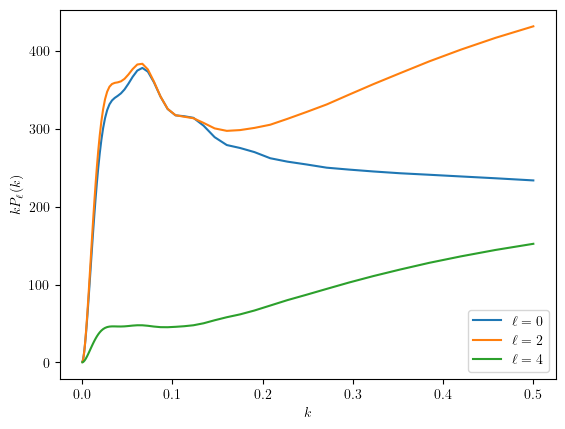

In [13]:
plt.plot(k, k*P0.get_Pl(θ, b, D), label = r"$\ell=0$")
plt.plot(k, k*P2.get_Pl(θ, b, D), label = r"$\ell=2$")
plt.plot(k, k*P4.get_Pl(θ, b, D), label = r"$\ell=4$")
plt.xlabel(r'$k$')
plt.ylabel(r'$kP_\ell(k)$')
plt.legend()

Text(0, 0.5, '$\\partial P_0(k)/\\partial\\alpha$')

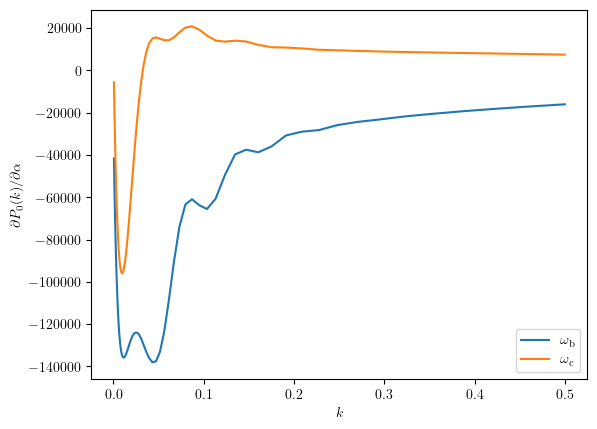

In [14]:
plt.plot(k, jacobian_P0[:,4], label = r"$\omega_\mathrm{b}$")
plt.plot(k, jacobian_P0[:,5], label = r"$\omega_\mathrm{c}$")
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'$\partial P_0(k)/\partial\alpha$')

Now, let us focus on some validations. How does it compare with the original `velocileptors`?

**Important**. Here everything is set to use the exact same settings used to create the training dataset. If you want something different this is fine, but you will need a different emulator. If you want to chang the input cosmological parameters, just change the initial dictionary.

In [31]:
# Generate multipoles using CLASS + PyBird (like in training data generation)
import numpy as np
from classy import Class
from velocileptors.EPT.ept_fullresum_fftw import REPT
from velocileptors.Utils.pnw_dst import pnw_dst


z = cosmo_dict["z"]

# Setup CLASS parameters
cosmo_params = {
    "output": "mPk",
    "P_k_max_h/Mpc": 20.0,
    "z_pk": "0.0,3.",
    "h": cosmo_dict["H0"] / 100,
    "omega_b": cosmo_dict["ombh2"],
    "omega_cdm": cosmo_dict["omch2"],
    "ln10^{10}A_s": cosmo_dict["ln10As"],
    "n_s": cosmo_dict["ns"],
    "tau_reio": 0.0568,
    "N_ur": 2.033,
    "N_ncdm": 1,
    "m_ncdm": cosmo_dict["Mν"],
    "use_ppf": "yes",
    "w0_fld": cosmo_dict["w0"],
    "wa_fld": cosmo_dict["wa"],
    "fluid_equation_of_state": "CLP",
    "cs2_fld": 1.0,
    "Omega_Lambda": 0.0,
    "Omega_scf": 0.0
}

# Initialize CLASS and compute
M = Class()
M.set(cosmo_params)
M.compute()

# Get growth rate
f = M.scale_independent_growth_factor_f(z)

# Generate k values and compute linear power spectrum
konhmin = 1e-3
konhmax = 10
nk = 20000
konh = np.logspace(np.log10(konhmin), np.log10(konhmax), nk)
plin = np.array([M.pk_cb(k * M.h(), z) * M.h()**3 for k in konh])

# Compute no-wiggle power spectrum using DST method
knw, Pnw = pnw_dst(konh, plin)

# Define target k-grid (from Julia code)
kv_target = np.concatenate(([0.0005,],
                             np.logspace(np.log10(0.0015), np.log10(0.025), 10, endpoint=True),
                             np.arange(0.03, 0.51, 0.01)))

# Initialize REPT with fine grid (will interpolate to target grid later if needed)
PT = REPT(knw, plin, pnw=Pnw, kmin=5e-4, kmax=0.5, nk=80,
          beyond_gauss=True, one_loop=True, N=2000, extrap_min=-6, extrap_max=2, cutoff=100, threads=1)

# Compute tables
PT.compute_redshift_space_power_multipoles_tables(f, apar=1.0543506224996766, aperp=1.040736963937694, ngauss=4)

# Combine bias terms to get final multipoles
k_v, P0_velocileptors, P2_velocileptors, P4_velocileptors = PT.compute_redshift_space_power_multipoles(b, f, apar=1.0543506224996766, aperp=1.040736963937694,)

print(f"CLASS+velocileptors computation complete!")

CLASS+velocileptors computation complete!


In [32]:
# Compare emulator vs CLASS+PyBird
# Compute with emulator
P0_emu = P0.get_Pl(θ, b, D)
P2_emu = P2.get_Pl(θ, b, D)
P4_emu = P4.get_Pl(θ, b, D)

Now, let us compare the two results! We will show both the two lines in the same plot and the percentage residuals.

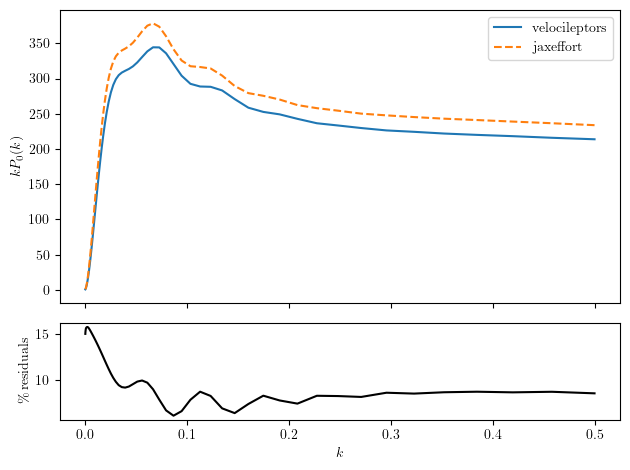

In [33]:
ratio  = P0_velocileptors / P0_emu

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*P0_velocileptors, label=r'$\mathrm{velocileptors}$')
ax_top.plot(k, k*P0_emu, label=r'$\mathrm{jaxeffort}$', linestyle ="--")
ax_top.set_ylabel(r'$kP_0(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

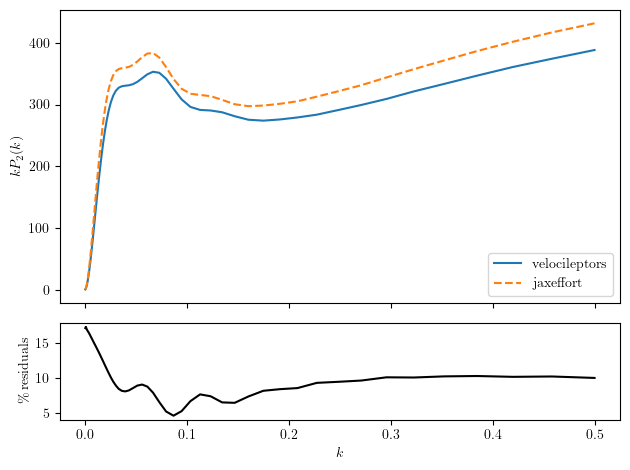

In [34]:
ratio  = P2_velocileptors / P2_emu  

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*P2_velocileptors, label=r'$\mathrm{velocileptors}$')
ax_top.plot(k, k*P2_emu, label=r'$\mathrm{jaxeffort}$', linestyle ="--")
ax_top.set_ylabel(r'$kP_2(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

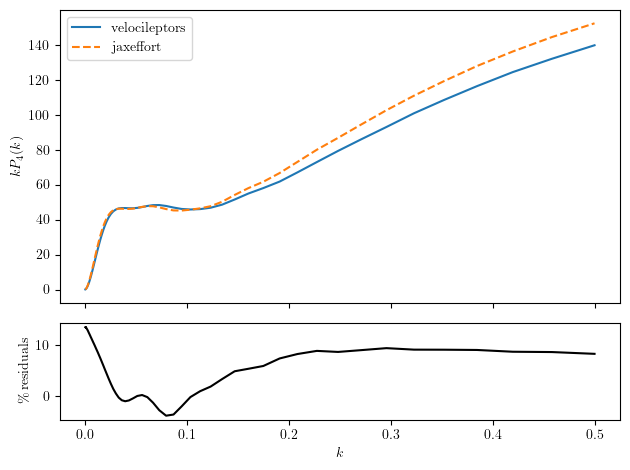

In [35]:
ratio = P4_velocileptors / P4_emu

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*P4_velocileptors, label=r'$\mathrm{velocileptors}$')
ax_top.plot(k, k*P4_emu, label=r'$\mathrm{jaxeffort}$', linestyle ="--")
ax_top.set_ylabel(r'$kP_4(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

In [36]:
P0_emu

Array([ 1879.29912935,  1973.94491618,  2076.11719213,  2187.04030325,
        2307.3188942 ,  2437.2546924 ,  2578.73226192,  2731.9888592 ,
        2898.0508792 ,  3077.7021824 ,  3271.11385569,  3479.39301778,
        3703.48103462,  3944.27990374,  4202.57726652,  4479.46365074,
        4775.25914817,  5090.80814257,  5426.61338693,  5782.5259673 ,
        6158.87648176,  6555.14922672,  6970.9078154 ,  7405.6111335 ,
        7857.53857247,  8325.32751237,  8807.30666364,  9300.04402658,
        9800.40234912, 10304.18015385, 10806.49284635, 11301.52751938,
       11782.10428016, 12240.62327338, 12667.99535928, 13054.36557352,
       13388.75657194, 13659.54056107, 13854.40262558, 13961.22126515,
       13968.32389043, 13865.62587509, 13645.2031503 , 13304.26788193,
       12844.20155525, 12274.43040304, 11612.51915641, 10884.55234891,
       10122.59745274,  9365.12986305,  8647.50077302,  7999.16263375,
        7436.3623092 ,  6956.2686751 ,  6531.65602   ,  6115.35919196,
      

In [29]:
P2_emu

Array([ 1280.51324571,  1389.57447287,  1507.64335392,  1636.10830753,
        1775.21456854,  1926.13451588,  2089.86390187,  2266.62991534,
        2459.4580092 ,  2667.2637358 ,  2890.81779084,  3130.81620113,
        3389.58184871,  3666.94561332,  3964.4979253 ,  4283.37701605,
        4623.75526797,  4986.8209405 ,  5373.59860983,  5783.81435442,
        6217.97155669,  6675.39016876,  7155.38110749,  7657.37239597,
        8180.69023232,  8720.42256628,  9277.20015561,  9845.91823038,
       10421.96336987, 11002.42850476, 11581.30408635, 12149.65343186,
       12702.29769906, 13228.95762399, 13719.13747133, 14162.89434393,
       14544.53978294, 14853.64644961, 15074.29076534, 15193.36534878,
       15196.11726003, 15072.88114853, 14813.1635461 , 14415.21436686,
       13881.71000332, 13223.1127846 , 12460.79241443, 11627.59254185,
       10758.06774143,  9898.01341439,  9086.03846745,  8356.1492781 ,
        7724.46502465,  7185.57797445,  6708.65105372,  6242.46816053,
      

In [30]:
P4_emu

Array([ 173.0303159 ,  187.70668896,  203.64468179,  220.89556317,
        239.63777632,  259.86708719,  281.96391761,  305.83121971,
        331.80100291,  359.85849398,  390.01241418,  422.41486365,
        457.45409767,  495.07910266,  535.23966732,  578.46223357,
        624.58933215,  673.686371  ,  726.10662499,  781.30547859,
        839.94973065,  901.5665585 ,  966.14207344, 1033.45988573,
       1103.62483404, 1176.36498038, 1250.9790704 , 1327.30032512,
       1404.41810824, 1482.2265018 , 1559.42055831, 1635.25628078,
       1708.47417096, 1778.19117527, 1842.56121272, 1899.83750076,
       1948.89456818, 1987.84129925, 2013.91079333, 2026.18054587,
       2022.15123656, 2000.81131227, 1960.8663653 , 1902.38603136,
       1825.49351438, 1732.34427554, 1625.80549971, 1510.59669674,
       1391.52353979, 1274.65224563, 1165.18073057, 1066.98605923,
        981.41092342,  907.73487367,  841.79959442,  778.07043312,
        712.37552866,  644.00006557,  577.6684795 ,  520.45085

In [38]:
P2_velocileptors

array([ 1061.14575735,  1151.0413899 ,  1248.58877993,  1354.3988802 ,
        1469.17123091,  1593.67137916,  1728.71703771,  1875.20194812,
        2034.11945935,  2206.34641463,  2392.3177426 ,  2592.70143961,
        2808.39106641,  3040.24445377,  3289.1074026 ,  3555.79934483,
        3841.04395277,  4145.49974533,  4469.69999138,  4814.03202925,
        5178.71629859,  5563.74087686,  5968.84431407,  6393.45306097,
        6836.61293138,  7296.96355416,  7772.65163313,  8261.23498383,
        8759.71481162,  9264.24684095,  9770.32230963, 10272.50003683,
       10764.41929509, 11238.80103501, 11687.26202626, 12100.25853414,
       12467.60798618, 12777.70145947, 13018.91876744, 13178.87902734,
       13245.56106693, 13207.84020348, 13056.9408851 , 12786.16005611,
       12394.9450924 , 11888.60758148, 11278.99190174, 10588.24198345,
        9847.43355544,  9087.86419046,  8349.91155844,  7667.27399582,
        7062.49069968,  6543.93484577,  6099.41277912,  5693.63606725,
      

In [39]:
P4_velocileptors

array([ 149.72868023,  162.40458183,  176.16806516,  191.0978245 ,
        207.29013668,  224.85680266,  243.90882669,  264.57729499,
        286.99476492,  311.31230952,  337.59029645,  365.91394873,
        396.40824715,  429.19992506,  464.4079572 ,  502.15455359,
        542.54434391,  585.67462959,  631.62662782,  680.45748478,
        732.20659893,  786.87347171,  844.43160046,  904.79799737,
        967.85319436, 1033.39393972, 1101.18250879, 1170.84973372,
       1242.00294615, 1314.06505984, 1386.42897909, 1458.27844003,
       1528.75204248, 1596.73956752, 1661.12602626, 1720.4281543 ,
       1773.2992836 , 1817.93635254, 1852.78679909, 1875.92206305,
       1885.75965041, 1880.48855344, 1859.04160114, 1820.23202842,
       1764.08965764, 1691.18036489, 1603.39061037, 1503.37121043,
       1396.03436542, 1285.40919919, 1177.28106588, 1076.4414183 ,
        986.19694965,  907.79312283,  840.29354587,  779.87885096,
        721.7969196 ,  662.01910869,  600.01339388,  539.41106